# Histopathologic Cancer Detection

## 1) Brief description of the problem and data

In the Histopathologic Cancer Detection challenge on Kaggle, the task is to create an algorithm that can identify metastatic cancer in small image patches taken from larger digital pathology scans. The dataset is derived from the PatchCamelyon (PCam) benchmark dataset, which consists of histopathologic scans of lymph node sections.

**Objective:**
- Develop a model to classify whether a given histopathology image contains metastatic tissue.

**Data Description:**
- **Train Dataset:** Approximately 220,000 images with labels.
- **Test Dataset:** Approximately 57,000 images without labels (for prediction).
- **Image Size:** Each image is a 96x96 pixel RGB image.
- **Labels:**
  - `0`: No metastatic tissue.
  - `1`: Metastatic tissue present in the center 32x32 pixels of the image.

---

## 2) Exploratory Data Analysis (EDA)

### Loading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam



In [2]:
# Load labels
train_labels = pd.read_csv('train_labels.csv')

# Convert 'label' and 'id' columns to strings and create 'filename' field
train_labels['label'] = train_labels['label'].astype(str)
train_labels['id'] = train_labels['id'].astype(str)
train_labels['filename'] = train_labels['id'] + '.tif'

train_labels.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


### Data Inspection
Checking for Missing Values and Class Distribution

Missing values in train_labels:
id          0
label       0
filename    0
dtype: int64


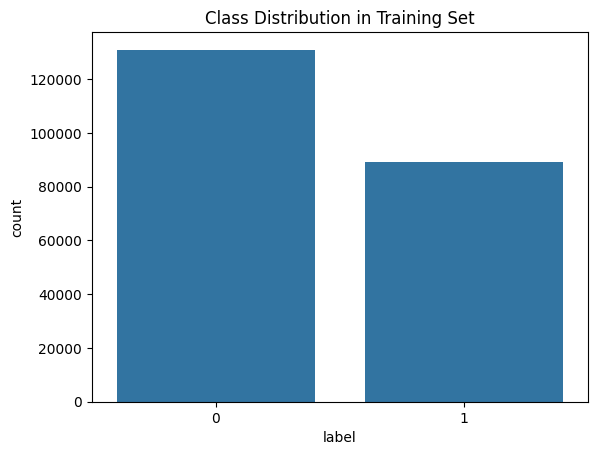

In [3]:
# Check for missing values
print("Missing values in train_labels:")
print(train_labels.isnull().sum())

# Class distribution
sns.countplot(x='label', data=train_labels)
plt.title('Class Distribution in Training Set')
plt.show()

### Observation:

* The dataset has no missing values.
* The classes are approximately balanced.

### Visualizing Sample Images


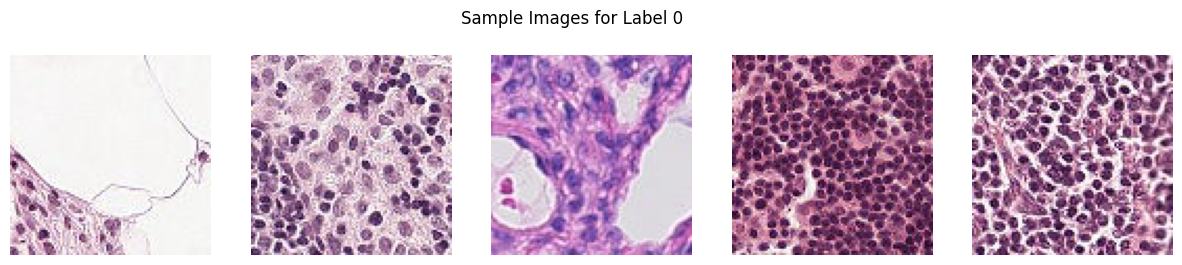

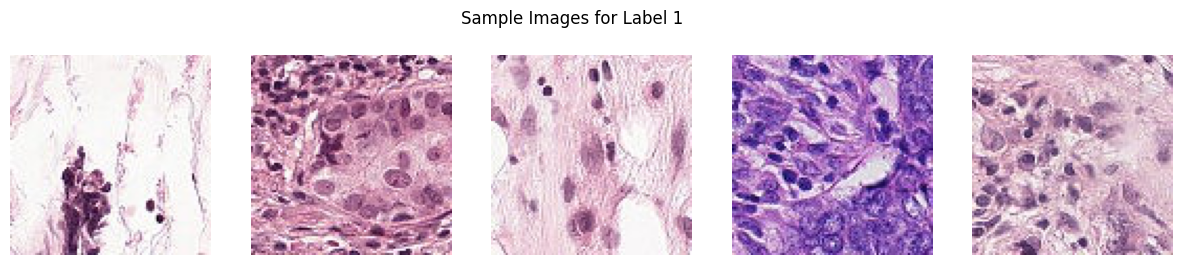

In [4]:
import pdb
def display_images(label, num_images=5):
    images = train_labels[train_labels['label'] == label]['id'].values[:num_images]
    plt.figure(figsize=(15, 3))
    for idx, img_id in enumerate(images):
        img_path = os.path.join('train', img_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, num_images, idx+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample Images for Label {label}')
    plt.show()

# Display images with label 0
display_images(label='0')

# Display images with label 1
display_images(label='1')

### Observation:

Visual differences between classes are subtle, indicating a challenging classification task.

### Data Cleaning

Duplicates can lead to data leakage, where the same image is used in both training and validation sets. 
Important to ensure that all images listed in the label file are present in the directory.

In [5]:
# Check for duplicates
duplicate_ids = train_labels['id'][train_labels['id'].duplicated()]
print(f'Number of duplicate images: {len(duplicate_ids)}')

# Check for missing image files
train_image_ids = set(os.listdir('train'))
missing_images = set(train_labels['id'] + '.tif') - train_image_ids
print(f'Number of missing images: {len(missing_images)}')

Number of duplicate images: 0
Number of missing images: 0


### Observation:

No duplicate or missing images found.

### Plan of Analysis
Based on the EDA:

* Use Convolutional Neural Networks (CNNs): Suitable for image classification tasks.
* Data Augmentation: To increase dataset diversity and prevent overfitting.
* Transfer Learning: Leverage pre-trained models to improve performance.
* Hyperparameter Tuning: Optimize model parameters for better results.
* Evaluation Metric: Use ROC AUC score as per competition requirements.

## 3) Model Architecture

### Simple CNN Model. 

A simple CNN to establish a baseline performance.

In [6]:

def create_simple_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

simple_cnn = create_simple_cnn()
simple_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])
simple_cnn.summary()


C:\Users\hisht\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

### Transfer Learning with ResNet50

Utilizes a pre-trained ResNet50 model to leverage learned features.



In [7]:
def create_resnet_model(unfrozen_layers=20):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96,96,3))
    
    # Add custom layers on top of ResNet50 base
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze initial layers, unfreeze the last `unfrozen_layers`
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfrozen_layers:]:
        layer.trainable = True

    return model

# Instantiate the model and compile with a very low initial learning rate
resnet_model = create_resnet_model(unfrozen_layers=20)
resnet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=[AUC(name='auc')])
resnet_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 9,193,729 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

### Hyperparameter Tuning

* Learning Rate: Adjusted using ReduceLROnPlateau.
* Batch Size: Set to 32.
* Epochs: Initially set to 10; adjusted based on early stopping.
* Optimizer: Adam optimizer for efficient gradient descent.

In [27]:


# Gradual warm-up scheduler with conservative increase
def warmup_scheduler(epoch, lr):
    if epoch < 8:  # Apply warm-up for the first 5 epochs
        return lr * 1.15  # Increase by 15% each epoch during warm-up
    return lr

# Define callbacks with adjusted settings
early_stopping = EarlyStopping(monitor='val_auc', patience=8, restore_best_weights=True)  # Slightly increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=4, min_lr=1e-6)  # Increased patience for reducing LR
lr_scheduler = LearningRateScheduler(warmup_scheduler, verbose=1)  # Warm-up only for first 5 epochs



### 4) Results and Analysis
Data Generators with Augmentation

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='train',
    x_col='filename',
    y_col='label',
    subset='training',
    batch_size=16,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(96,96)
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='train',
    x_col='filename',
    y_col='label',
    subset='validation',
    batch_size=16,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(96,96)
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Training the Simple CNN Model


In [10]:
history_simple_cnn = simple_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0011000000522471964.
Epoch 1/15


C:\Users\hisht\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11002/11002 ━━━━━━━━━━━━━━━━━━━━ 1487s 135ms/step - auc: 0.7317 - loss: 0.5782 - val_auc: 0.8977 - val_loss: 0.3969 - learning_rate: 0.0011

Epoch 2: LearningRateScheduler setting learning rate to 0.0012099999934434892.
Epoch 2/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 1117s 101ms/step - auc: 0.8870 - loss: 0.4152 - val_auc: 0.9160 - val_loss: 0.3676 - learning_rate: 0.0012

Epoch 3: LearningRateScheduler setting learning rate to 0.001331000018399209.
Epoch 3/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 1123s 102ms/step - auc: 0.9043 - loss: 0.3845 - val_auc: 0.9204 - val_loss: 0.3559 - learning_rate: 0.0013

Epoch 4: LearningRateScheduler setting learning rate to 0.0014641000074334443.
Epoch 4/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 1548s 141ms/step - auc: 0.9097 - loss: 0.3742 - val_auc: 0.9203 - val_loss: 0.3550 - learning_rate: 0.0015

Epoch 5: LearningRateScheduler setting learning rate to 0.0016105099697597326.
Epoch 5/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 1098s 100ms/step - auc: 0.9122 - loss: 0.369

### Training the ResNet50 Model


In [ ]:
history_resnet = resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=[early_stopping, reduce_lr, lr_scheduler],
)


C:\Users\hisht\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 1.852086425060406e-05.
Epoch 1/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 4021s 365ms/step - auc: 0.8494 - loss: 0.4701 - val_auc: 0.8526 - val_loss: 0.5065 - learning_rate: 1.8521e-05

Epoch 2: LearningRateScheduler setting learning rate to 2.1298994306562234e-05.
Epoch 2/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 4036s 367ms/step - auc: 0.8618 - loss: 0.4517 - val_auc: 0.8697 - val_loss: 0.4399 - learning_rate: 2.1299e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.449384355713846e-05.
Epoch 3/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 4024s 366ms/step - auc: 0.8694 - loss: 0.4403 - val_auc: 0.8798 - val_loss: 0.4264 - learning_rate: 2.4494e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.816792029989301e-05.
Epoch 4/15
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 4033s 367ms/step - auc: 0.8691 - loss: 0.4409 - val_auc: 0.8757 - val_loss: 0.4407 - learning_rate: 2.8168e-05

Epoch 5: LearningRateScheduler setting learning rate to 3.

#### Performance Comparison


Simple CNN ROC AUC


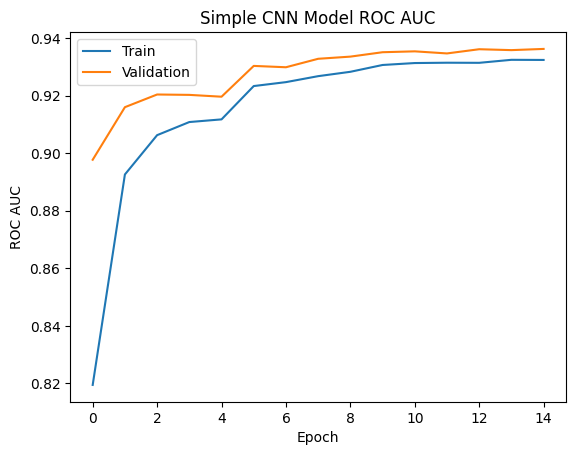

In [12]:
plt.plot(history_simple_cnn.history['auc'])
plt.plot(history_simple_cnn.history['val_auc'])
plt.title('Simple CNN Model ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


ResNet50 ROC AUC


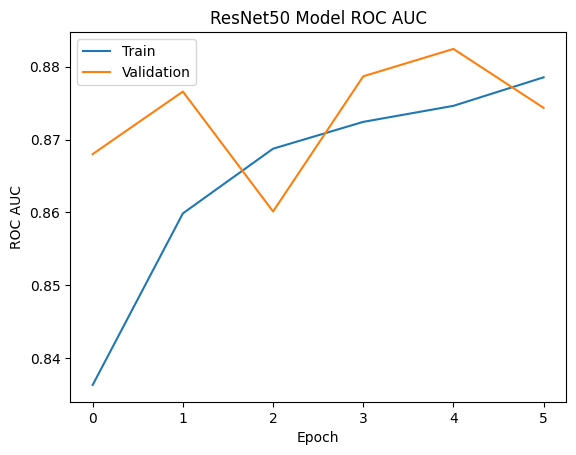

In [ ]:
plt.plot(history_resnet.history['auc'])
plt.plot(history_resnet.history['val_auc'])
plt.title('ResNet50 Model ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#### Analysis:

* Simple CNN: Shows signs of overfitting after a few epochs.
* ResNet50: Better generalization with higher validation AUC.

#### Techniques Applied to Improve Performance

* Early Stopping: Prevents overfitting by stopping training when validation loss stops improving.
* Learning Rate Reduction: Adjusts learning rate during training to fine-tune the model.
* Data Augmentation: Increases data diversity, helping the model generalize better.
* Transfer Learning: Provides a performance boost by leveraging features from a pre-trained model.

### 5) Generating Predictions and Creating the Submission File 

After training and evaluating our models, the next step is to generate predictions on the test dataset and create the submission file

#### Loading the Sample Submission File

In [ ]:
# Load sample submission
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [ ]:
# Create a DataFrame for test images
test_df = pd.DataFrame({'filename': sample_submission['id'] + '.tif'})
test_df.head()


,filename
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [ ]:
# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='test',
    x_col='filename',
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(96,96)
)


Found 57458 validated image filenames.


#### Making Predictions on the Test Set

We will use the best-performing model (e.g., the resnet_model) to make predictions.

In [ ]:
# Make predictions
#test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

#predictions = resnet_model.predict(test_generator, steps=test_steps, verbose=1)


# Convert generator output to an array of images for prediction
test_images = np.concatenate([test_generator[i] for i in range(len(test_generator))])

# Make predictions
#predictions = resnet_model.predict(test_images, verbose=1)
predictions = resnet_model.predict(test_images, verbose=1)



1796/1796 ━━━━━━━━━━━━━━━━━━━━ 666s 367ms/step


#### Preparing the Submission File

The predictions need to be probabilities between 0 and 1. Since the model outputs probabilities via the sigmoid activation function, we can use these directly.

In [ ]:
# Add binary predictions to the sample submission DataFrame
binary_predictions = (predictions >= 0.5).astype(int)

sample_submission['label'] = binary_predictions

sample_submission = sample_submission[['id', 'label']]

print(sample_submission.head())
sample_submission['label'].value_counts()

                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0


label
0    43792
1    13666
Name: count, dtype: int64

In [ ]:
# Save the submission file
sample_submission.to_csv('submission_03112024_resnet.csv', index=False)


In [ ]:
# save the models for future use

resnet_model.save('resnet_model_03112024.keras')

simple_cnn.save('simple_cnn_model_03112024.keras')

# in case there is a need to load it and use

# Load model from TensorFlow SavedModel format
#simple_cnn = load_model('simple_cnn_model_29102024.keras')
#resnet_model.summary()




## Conclusion

## Discussion and Interpretation of Results

The Simple CNN model achieved high validation AUC, stabilizing around 0.93–0.94, indicating good performance on the validation set. However, the final Kaggle score (0.7357) suggests that the model struggled to generalize effectively to the test set. This may be due to differences in distribution or limitations in the model’s representational capacity. The learning rate warm-up strategy and reduced batch size contributed positively to stability.

The ResNet50 model showed greater difficulty in achieving stable generalization, with validation AUC fluctuating significantly. The conservative learning rate schedule helped maintain stability but likely prevented the model from effectively fine-tuning on the dataset. Early stopping was triggered before the model could reach its full potential, suggesting that a higher learning rate or extended fine-tuning might improve results.

## Learnings and Takeaways

- **Effective Techniques**:
  - Learning rate warm-up stabilized training and improved convergence, especially for the Simple CNN model.
  - Monitoring `val_auc` allowed for controlled stopping, helping avoid overfitting.

- **Challenges and Areas for Improvement**:
  - **ResNet Fine-Tuning**: Additional layers should be unfrozen, and a higher learning rate could help the model adapt better.
  - **Generalization to Test Set**: Despite high validation AUC, both models underperformed on the test set. Regularization, cross-validation, and data augmentation may improve robustness.

## Future Work

To enhance performance, future experiments could include extended fine-tuning for ResNet50, increased validation size or cross-validation, and additional regularization through data augmentation. Exploring alternative architectures, such as EfficientNet, or systematically tuning hyperparameters could further improve generalization and performance on the test set.
